<a href="https://colab.research.google.com/github/maxreynolds/Pattern-Cloud/blob/main/accelerate_via_subprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!cd /content/
!git clone https://github.com/maxreynolds/diffusers.git
!pip install ./diffusers
!pip install -U -r /content/diffusers/examples/text_to_image/requirements.txt

Cloning into 'diffusers'...
remote: Enumerating objects: 31853, done.
remote: Total 31853 (delta 0), reused 0 (delta 0), pack-reused 31853
Receiving objects: 100% (31853/31853), 23.83 MiB | 22.72 MiB/s, done.
Resolving deltas: 100% (23738/23738), done.
Processing ./diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.4 MB/s eta 0:00:00
  Created wheel for diffusers: filename=diffusers-0.22.0.dev0-py3-none-any.whl size=1552454 sha256=5f92422a2ed37793671654f0ee6a855b8f4e8d4569da2bbe494a3268c1c35fee
  Stored in directory: /tmp/pip-ephem-wheel-cache-wi4qx52f/wheels/95/c5/3b/e1b4269f8a2584de57e75f949a185b48fc4144e9a91fc9965a
Successfully built diffusers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 28.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [3]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:
!accelerate config default --mixed_precision fp16

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [8]:
%%writefile test.py
import subprocess
import numpy as np

num_train_steps = 250

subprocess.run(["accelerate", "launch", "diffusers/examples/text_to_image/train_text_to_image.py",
  "--pretrained_model_name_or_path=CompVis/stable-diffusion-v1-4",
  "--dataset_name=MaxReynolds/MyPatternDataset",
  "--use_ema",
  "--resolution=512",
  "--center_crop",
  "--random_flip",
  "--train_batch_size=1",
  "--gradient_accumulation_steps=4",
  "--gradient_checkpointing",
  f"--max_train_steps={num_train_steps}",
  "--learning_rate=1e-05",
  "--max_grad_norm=1",
  "--checkpointing_steps=100000",
  "--lr_scheduler=constant",
  "--lr_warmup_steps=0",
  "--push_to_hub",
  "--output_dir=MaxReynolds/MyStreamlitModel",
  "--validation_prompt=<r4nd0m-l4b3l>",
  "--report_to=wandb"])



Overwriting test.py


In [9]:
!python test.py

2023-11-02 01:11:47.638790: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 01:11:47.638838: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 01:11:47.638868: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-02 01:11:48.827508: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
11/02/2023 01:11:49 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'timestep_spacing', 'sample_max_value', 'clip_sample_range', 'dynamic_

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

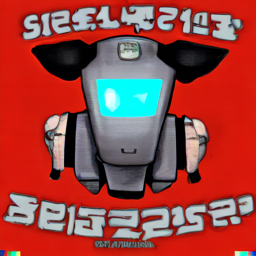

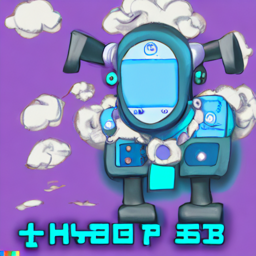

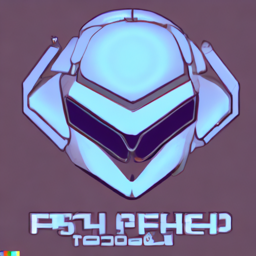

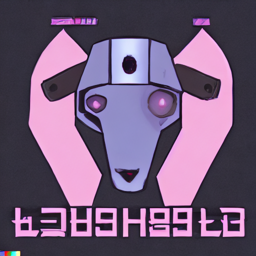

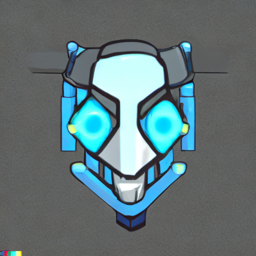

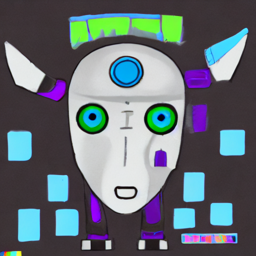

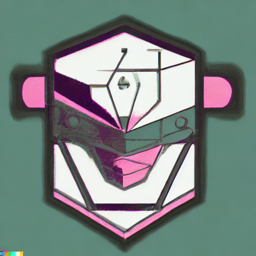

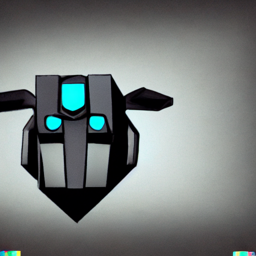

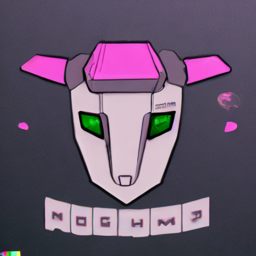

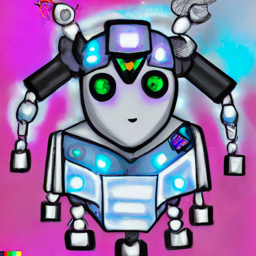

In [11]:
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image

# Setting model path to the model we just trained
model_path = 'MaxReynolds/MyStreamlitModel'
pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16)
pipe.to("cuda")

my_prompt = "<r4nd0m-l4b3l>"
num_images = 10

# Run inference using above prompt to acquire some number of images
all_images = [pipe(prompt=my_prompt).images[0] for i in range(num_images)]
for idx, image in enumerate(all_images):
  image = image.resize((256, 256))
  image.save(f"image{idx}.png")
  display(image)
